# Pryngles module: Science

In [2]:
from pryngles import *

## External modules

In [3]:
import numpy as np
import math as mh
import spiceypy as spy
from scipy.integrate import quad
from scipy.spatial import ConvexHull
from celluloid import Camera # getting the camera
import rebound as rb
import matplotlib.pyplot as plt

## The Science class

The Science class is a class with routines intended to perform a wide diversity of mathematical, physical and astronomical calculations.

In [4]:
class Science(PrynglesCommon):pass

### Cartesian to spherical

In [5]:
def spherical(xyz):
    """
    Transform cartesian coordinates into spherical coordinates

    Parameters:

        xyz: array (3):
            Cartesian coordinates

    Return:

        rqf: array (3):
            Spherical coordinates (r, theta, phi) where theta is azimutal angle and phi is 
            elevation (complement of polar angle).                

            Notice that this convention is different than that of regular vectorial calculus
            where spherical coordinates are (r,theta,phi), but theta is the polar angle and phi 
            the ezimutal one.

    """
    r,theta,phi=spy.reclat(np.array(xyz))
    theta=2*mh.pi+theta if theta<0 else theta

    return np.array([r,theta,phi])

def cospherical(xyz):
    """Transform cartesian coordinates into cosine/sine of spherical angles
    
    Parameters:

        xyz: array (3):
            Cartesian coordinates
            
    Return:

        cqsqcf: array (3):
            Cosine/sine of spherical angles (cos theta, sin theta, cos phi) where theta is 
            azimutal angle and phi is elevation (complement of polar angle).         
    """
    rho=(xyz[0]**2+xyz[1]**2)**0.5
    sf=xyz[2]/(rho**2+xyz[2]**2)**0.5
    cq=xyz[0]/rho if not mh.isclose(rho,0) else 1
    sq=xyz[1]/rho if not mh.isclose(rho,0) else 0
    return np.array([cq,sq,sf])

def pcylindrical(xyz):
    """Transform cartesian coordinates into pseudo cylindrical coordinates
    
    Parameters:

        xyz: array (3):
            Cartesian coordinates
            
    Return:

        rhoazcf: array (3):
            Cylindrical coordinates expresed as rho, phi (azimutal angle) and cos(theta) (cosine
            of polar angle).    
    """
    rho=(xyz[0]**2+xyz[1]**2)**0.5
    r=(xyz[2]**2+rho**2)**0.5
    phi=mh.atan2(xyz[1],xyz[0])
    phi=phi if phi>0 else 2*np.pi+phi
    cost=xyz[2]/r if not mh.isclose(r,0) else mh.copysign(1,xyz[2])
    return np.array([rho,phi,cost])

def cartesian(rqf):
    """
    Transform cartesian coordinates into spherical coordinates

    Parameters:

        xyz: array (3):
            Cartesian coordinates

    Return:

        rqf: array (3):
            Spherical coordinates (r, theta, phi) where theta is azimutal angle and phi is 
            elevation (complement of polar angle).                

            Notice that this convention is different than that of regular vectorial calculus
            where spherical coordinates are (r,theta,phi), but theta is the polar angle and phi 
            the ezimutal one.

    """
    return spy.latrec(rqf[0],rqf[1],rqf[2])

def direction(*args):
    """Calculate the direction on which a vector is pointing
    
    Parameters:
        args: array:
            If len(args)==2, components are longitude and latitude of the direction (in degrees).
            If len(args)==3, components are cartisian coordinates of the vector n.
            
    Return:

        If len(args)==2:
        
            vx,vy,vz: float:
                Cartesian components of the vector.

        If len(args)==2:
    
            lamb: float [degrees]:
                Longitude (angle with respect to x-axis).

            beta: float [degrees]:
                Latitude (elevation angle with respect to xy-plane).
    """
    if len(args)==3:
        rqf=spherical(list(args))
        return rqf[1]*Consts.rad,rqf[2]*Consts.rad
    elif len(args)==2:
        if abs(args[1])>90:
            raise ValueError("Elevation angle should be in the interval [-90,90]")
        nvec=cartesian([1,args[0]*Consts.deg,args[1]*Consts.deg])
        return nvec
    else:
        raise ValueError("You provided a wrong number of arguments '{args}'.  It should be 2 or 3'")
    
Science.spherical=spherical
Science.cospherical=cospherical
Science.pcylindrical=pcylindrical
Science.cartesian=cartesian
Science.direction=direction

In [6]:
if IN_JUPYTER:
    def test_coords(self):
        
        #Test axis
        axis=[
            [+1,+0,+0],[-1,+0,+0],
            [+0,+1,+0],[+0,-1,+0],
            [+0,+0,+1],[+0,+0,-1],
        ]
        for i,xyz in enumerate(axis):
            rqf=Science.spherical(xyz)
            cqsqsf=Science.cospherical(xyz)
            rhofct=Science.pcylindrical(xyz)
            print(f"Axis {i+1}:")
            print("\tSpherical:",rqf[0],rqf[1]*Consts.rad,rqf[2]*Consts.rad)
            print("\tCospherical:",cqsqsf)
            print("\tVerify:",mh.cos(rqf[1]),mh.sin(rqf[1]),mh.sin(rqf[2]))
            print("\tPseudo cilyndrical:",rhofct)
            print("\tVerify:",rqf[0]*np.cos(rqf[2]),rqf[1],mh.sin(rqf[2]))

        #Test spherical
        octants=[
            [+1,+1,+1],[-1,+1,+1],[-1,-1,+1],[+1,-1,+1],
            [+1,+1,-1],[-1,+1,-1],[-1,-1,-1],[+1,-1,-1]
        ]
        for i,xyz in enumerate(octants):
            rqf=Science.spherical(xyz)
            cqsqsf=Science.cospherical(xyz)
            rhofct=Science.pcylindrical(xyz)
            print(f"Octant {i+1}:")
            print("\tSpherical:",rqf[0],rqf[1]*Consts.rad,rqf[2]*Consts.rad)
            print("\tCospherical:",cqsqsf)
            print("\tVerify:",mh.cos(rqf[1]),mh.sin(rqf[1]),mh.sin(rqf[2]))
            print("\tPseudo cilyndrical:",rhofct)
            print("\tVerify:",rqf[0]*np.cos(rqf[2]),rqf[1],mh.sin(rqf[2]))
            
        #Test cartesian
        octants=[
            [1,45*Consts.deg,45*Consts.deg],[1,135*Consts.deg,45*Consts.deg],
            [1,225*Consts.deg,45*Consts.deg],[1,315*Consts.deg,45*Consts.deg],
            [1,45*Consts.deg,-45*Consts.deg],[1,135*Consts.deg,-45*Consts.deg],
            [1,225*Consts.deg,-45*Consts.deg],[1,315*Consts.deg,-45*Consts.deg]
        ]
        for i,rqf in enumerate(octants):
            xyz=Science.cartesian(rqf)
            print(f"Octant {i+1}:",xyz) 
            
        #Test direction
        nvec=direction(120,45)
        print(nvec,direction(*nvec))

    class Test(unittest.TestCase):pass
    Test.test_coords=test_coords
    unittest.main(argv=['first-arg-is-ignored'],exit=False)

.

Axis 1:
	Spherical: 1.0 0.0 0.0
	Cospherical: [1. 0. 0.]
	Verify: 1.0 0.0 0.0
	Pseudo cilyndrical: [1.         6.28318531 0.        ]
	Verify: 1.0 0.0 0.0
Axis 2:
	Spherical: 1.0 180.0 0.0
	Cospherical: [-1.  0.  0.]
	Verify: -1.0 1.2246467991473532e-16 0.0
	Pseudo cilyndrical: [1.         3.14159265 0.        ]
	Verify: 1.0 3.141592653589793 0.0
Axis 3:
	Spherical: 1.0 90.0 0.0
	Cospherical: [0. 1. 0.]
	Verify: 6.123233995736766e-17 1.0 0.0
	Pseudo cilyndrical: [1.         1.57079633 0.        ]
	Verify: 1.0 1.5707963267948966 0.0
Axis 4:
	Spherical: 1.0 270.0 0.0
	Cospherical: [ 0. -1.  0.]
	Verify: -1.8369701987210297e-16 -1.0 0.0
	Pseudo cilyndrical: [1.         4.71238898 0.        ]
	Verify: 1.0 4.71238898038469 0.0
Axis 5:
	Spherical: 1.0 0.0 90.0
	Cospherical: [1. 0. 1.]
	Verify: 1.0 0.0 1.0
	Pseudo cilyndrical: [0.         6.28318531 1.        ]
	Verify: 6.123233995736766e-17 0.0 1.0
Axis 6:
	Spherical: 1.0 0.0 -90.0
	Cospherical: [ 1.  0. -1.]
	Verify: 1.0 0.0 -1.0
	Pseudo ci


----------------------------------------------------------------------
Ran 1 test in 0.009s

OK


In [7]:
def rotation_matrix(ez,alpha):
    """
    Set a rotation matrix from the direction of the ez vector and a rotation angle alpha
    
    Parameter:
        ez: array (3)
            vector in the direction of the z-axis. 
            
        alpha: float (3) [rad]
            Rotation angle of the x-axis around z-axis (clockwise)
            
    Return:
        Msys2uni: float (3x3)
            Rotation matrix from the system defined by ez and the universal system.
            
        Muni2sys: float (3x3)
            Rotation matrix from the universal system to the system defined by ez
    """
    ez,one=spy.unorm(ez)
    ex=spy.ucrss([0,0,1],ez) #Spice is 5 faster for vcrss
    if spy.vnorm(ex)==0:
        ex=np.array([1,0,0]) if np.sum(ez)>0 else np.array([-1,0,0])
    ey=spy.ucrss(ez,ex)
    Msys2uni=np.array(list(np.vstack((ex,ey,ez)).transpose())).reshape((3,3))
    Muni2sys=spy.invert(Msys2uni)
    verbose(VERB_VERIFY,"Rotation axis:",ex,ey,ez)
    return Msys2uni,Muni2sys

Science.rotation_matrix=rotation_matrix

In [11]:
if IN_JUPYTER:
    def test_rot(self):
        
        Verbose.VERBOSITY=VERB_ALL
        
        #Test rotation
        Msys2uni,Muni2sys=Science.rotation_matrix([0,0,1],0)
        print(Msys2uni)

        Msys2uni,Muni2sys=Science.rotation_matrix([1,0,-1],0)
        print(Msys2uni)
        print(Muni2sys)

        Verbose.VERBOSITY=VERB_NONE

    class Test(unittest.TestCase):pass
    Test.test_rot=test_rot
    unittest.main(argv=['first-arg-is-ignored'],exit=False)

.

      VERB3::rotation_matrix:: Rotation axis: [1 0 0] [0. 1. 0.] [0. 0. 1.]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
      VERB3::rotation_matrix:: Rotation axis: [-0.  1.  0.] [0.70710678 0.         0.70710678] [ 0.70710678  0.         -0.70710678]
[[-0.          0.70710678  0.70710678]
 [ 1.          0.          0.        ]
 [ 0.          0.70710678 -0.70710678]]
[[-0.          1.          0.        ]
 [ 0.70710678  0.          0.70710678]
 [ 0.70710678  0.         -0.70710678]]



----------------------------------------------------------------------
Ran 1 test in 0.022s

OK


In [12]:
Science.LIMB_NORMALIZATIONS=dict()

In [13]:
def limb_darkening(rho,cs=[0.6562],N=None):
    """Limb darkening computation
    
    Parameters:
        rho: float:
            Distance to center of the star in units of stellar radius.
            
        cs: list, default = [0.6562]:
            List of limb darkening coefficients.
            
        N: float, default = 1:
            Normalization constant.
            
    Return:
        I: float:
            Normalized intensity of the star at rho.
    
    Notes: 
        Models in: https://pages.jh.edu/~dsing3/David_Sing/Limb_Darkening.html
        Coefficients available at: https://pages.jh.edu/~dsing3/LDfiles/LDCs.CoRot.Table1.txt

    Test code:
    
        fig=plt.figure()
        ax=fig.gca()
        rhos=np.linspace(0,1,100)
        Rs=1
        coefs=[0.6550]
        N=Util.limbDarkeningNormalization(coefs)
        ax.plot(rhos,Util.limbDarkening(rhos,Rs,coefs,N))
        coefs=[0.6022,0.0654]
        N=Util.limbDarkeningNormalization(coefs)
        ax.plot(rhos,Util.limbDarkening(rhos,Rs,coefs,N))
        coefs=[0.9724,-0.4962,0.2029]
        N=Util.limbDarkeningNormalization(coefs)
        ax.plot(rhos,Util.limbDarkening(rhos,Rs,coefs,N))        
    """
    mu=(1-rho**2)**0.5
    order=len(cs)
    
    #Calculate normalization constant
    if N is None:
        chash=hash(tuple(cs))
        if chash in Science.LIMB_NORMALIZATIONS:
            N=Science.LIMB_NORMALIZATIONS[chash]
        else:
            integrand=lambda rho:Science.limb_darkening(rho,cs,N=1)*2*np.pi*rho
            N=quad(integrand,0.0,1.0,epsrel=1e-5)[0]
            verbose(VERB_VERIFY,f"Normalization of limb darkening function for cs = {cs}, N = {N}")
            Science.LIMB_NORMALIZATIONS[chash]=N
            
    if order==0:
        I=np.ones_like(rho)
    elif order==1:
        I=1-cs[0]*(1-mu)
    elif order==2:
        I=1-cs[0]*(1-mu)-cs[1]*(1-mu)**2
    elif order==3:
        I=1-cs[0]*(1-mu)-cs[1]*(1-mu**1.5)-cs[2]*(1-mu**2)
    elif order==4:
        I=1-cs[0]*(1-mu**0.5)-cs[1]*(1-mu)-cs[2]*(1-mu**1.5)-cs[3]*(1-mu**2)
    else:
        raise ValueError(f"Limb darkening not implemented for order {order}")
    return I/N

Science.limb_darkening=limb_darkening

      VERB3::limb_darkening:: Normalization of limb darkening function for cs = [0.2333537675177354], N = 2.89722515968272
0.31294029390943


<IPython.core.display.Javascript object>


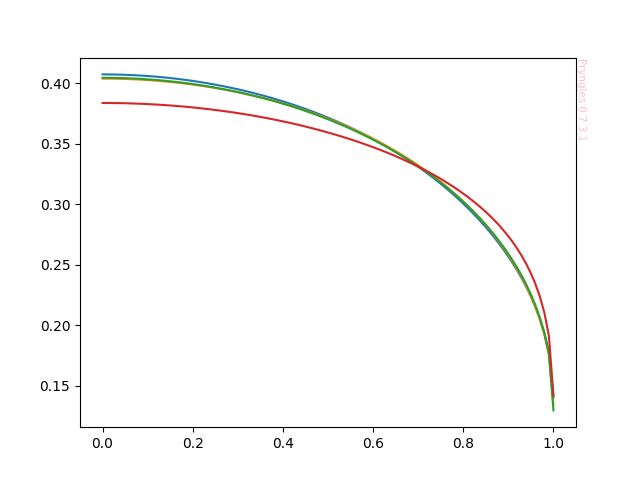

.

      VERB3::limb_darkening:: Normalization of limb darkening function for cs = [0.655], N = 2.45567825755602
      VERB3::limb_darkening:: Normalization of limb darkening function for cs = [0.6022, 0.0654], N = 2.4767269283350704
      VERB3::limb_darkening:: Normalization of limb darkening function for cs = [0.9724, -0.4962, 0.2029], N = 2.472665297844586
      VERB3::limb_darkening:: Normalization of limb darkening function for cs = [-0.2018, 2.1, -2.0247, 0.7567], N = 2.6067005991229735



----------------------------------------------------------------------
Ran 1 test in 0.078s

OK


In [10]:
if IN_JUPYTER:
    def test_limb(self):
        
        Verbose.VERBOSITY=VERB_ALL

        cs=[np.random.rand()]
        I=Science.limb_darkening(0.8,cs)
        print(I)
        
        fig=plt.figure()
        ax=fig.gca()

        rhos=np.linspace(0,1,100)
        coefs=[0.6550]
        ax.plot(rhos,Science.limb_darkening(rhos,coefs))
        coefs=[0.6022,0.0654]
        ax.plot(rhos,Science.limb_darkening(rhos,coefs))
        coefs=[0.9724,-0.4962,0.2029]
        ax.plot(rhos,Science.limb_darkening(rhos,coefs))    
        coefs=[-0.2018,2.1000,-2.0247,0.7567]
        ax.plot(rhos,Science.limb_darkening(rhos,coefs))
        Plot.pryngles_mark(ax)
        
        Verbose.VERBOSITY=VERB_NONE

    class Test(unittest.TestCase):pass
    Test.test_limb=test_limb
    unittest.main(argv=['first-arg-is-ignored'],exit=False)

In [11]:
def get_convexhull(data):
    if len(data)>0:
        try:
            qhull=ConvexHull(data)
        except:
            qhull=None
    else:
        qhull=None
    return qhull
    
Science.get_convexhull=get_convexhull

def points_in_hull(p, hull, tol=1e-12):
    """Determine if a set of points are inside a convex hull.
    
    Parameters:
        
        p: numpy array (Nx2):
            Set of coordinates for points to evaluate.
    
        hull: ConvexHull:
            Convex hull to evaluate.
            
    Return:
    
        inside: boolean array (N):
            Boolean array telling if points are inside the convex hull.
            
    Examples:
        
        import numpy as np
        
        rng = np.random.default_rng()
        points = rng.random((30, 2))
        hull = ConvexHull(points)
        
        ps = rng.random((30, 2))-0.5
        cond=points_in_hull(ps,hull)

        import matplotlib.pyplot as plt
        
        for simplex in hull.simplices:
            plt.plot(points[simplex, 0], points[simplex, 1], 'k-')

        for p in ps[cond]:
            plt.plot(p[0],p[1],'r*')

        for p in ps[~cond]:
            plt.plot(p[0],p[1],'co')
            
            
    Notes:
        Taken from https://stackoverflow.com/a/72483841
    """
    return np.all(hull.equations[:,:-1] @ p.T + np.repeat(hull.equations[:,-1][None,:], len(p), axis=0).T <= tol, 0)

Science.points_in_hull=points_in_hull

30 30


<IPython.core.display.Javascript object>


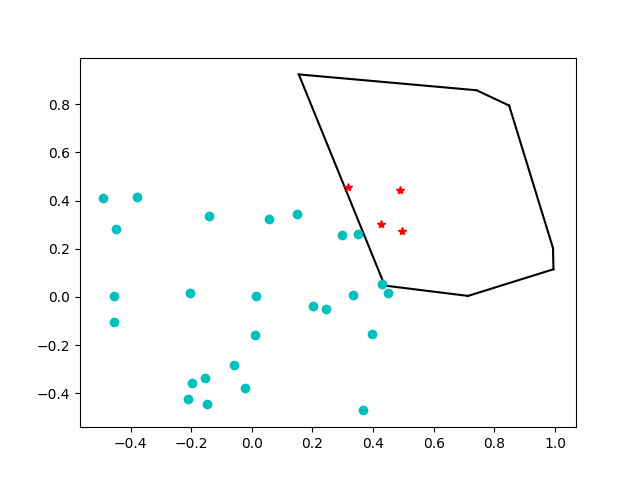

.
----------------------------------------------------------------------
Ran 1 test in 0.038s

OK


In [12]:
if IN_JUPYTER:
    def test_hull(self):
        
        Verbose.VERBOSITY=VERB_ALL

        rng = np.random.default_rng()
        points = rng.random((30, 2))
        hull = Science.get_convexhull(points)

        ps = rng.random((30, 2))-0.5
        cond=Science.points_in_hull(ps,hull)
        print(len(cond),len(ps))

        import matplotlib.pyplot as plt
        plt.figure()
        for simplex in hull.simplices:
            plt.plot(points[simplex, 0], points[simplex, 1], 'k-')

        for p in ps[cond]:
            plt.plot(p[0],p[1],'r*')

        for p in ps[~cond]:
            plt.plot(p[0],p[1],'co')
        
        Verbose.VERBOSITY=VERB_NONE

    class Test(unittest.TestCase):pass
    Test.test_hull=test_hull
    unittest.main(argv=['first-arg-is-ignored'],exit=False)

## Plane

In [24]:
class Plane(PrynglesCommon):
    """A plane in 3d.
    
    Initialization parameters:
        
        p1,p2,p3: array(3):
            Points on the plane.
            
    Attributes:
        a,b,c,d: float:
            Coefficients of the equation of the plane.
            a x + b y + c z + d = 0
            
    Notes:
        This class has been optimized removing all vectorial
        operations. This reduce considerably the execution time.
    """
    def __init__(self,p1,p2,p3):
        x1,y1,z1=p1
        x2,y2,z2=p2
        x3,y3,z3=p3
        
        a1 = x2 - x1
        b1 = y2 - y1
        c1 = z2 - z1
        a2 = x3 - x1
        b2 = y3 - y1
        c2 = z3 - z1

        self.a = b1 * c2 - b2 * c1
        self.b = a2 * c1 - a1 * c2
        self.c = a1 * b2 - b1 * a2
        self.d = (- self.a * x1 - self.b * y1 - self.c * z1)
                
        #Save components of the defining points
        self.p1x = p1[0];self.p1y = p1[1];self.p1z = p1[2]
        self.p2x = p2[0];self.p2y = p2[1];self.p2z = p2[2]
        self.p3x = p3[0];self.p3y = p3[1];self.p3z = p3[2]

        #Normal vector
        self.normal=(self.a**2+self.b**2+self.c**2)**0.5
        self.nx=self.a/self.normal
        self.ny=self.b/self.normal
        self.nz=self.c/self.normal
    
    def get_projection(self,p):
        """Find the projected point on the surface of the plane.
        
        Parameters:
            p: list (3):
                Coordinates of the point.
        
        Return:
            v: list (3):
                Coordinates of projection point.
                
            d: float:
                Distance.
        """
        
        #Distance
        d=abs(self.a*p[0]+self.b*p[1]+self.c*p[2]+self.d)/self.normal
        
        #Vectorial equivalent np.dot(p-self.p1,self.n)
        pdn=(p[0]-self.p1x)*self.nx+(p[1]-self.p1y)*self.ny+(p[2]-self.p1z)*self.nz

        #Vectorial equivalent v=p-np.dot(p-self.p1,self.n)*self.n
        v=[0]*3
        v[0]=p[0]-pdn*self.nx
        v[1]=p[1]-pdn*self.ny
        v[2]=p[2]-pdn*self.nz
        
        return v,d
    
    def get_z(self,x,y):
        """Get z value of a plane corresponding to given x, y coordinates.
        """
        z = (-self.a*x-self.b*y-self.d)/self.c if not mh.isclose(self.c,0) else np.nan
        return z
    
    def is_above(self,p,vdir):
        """Check if a point is above or below a plane with respect to a given direction
        
        Parameters:
            p: list (3):
                Coordinates of the point.
                
            vidr: list (3):
                Direction with respect to
        """
        v,d=self.get_projection(p)        
        #Sign of (v-p).vdir
        cdir=(v[0]-p[0])*vdir[0]+(v[1]-p[1])*vdir[1]+(v[2]-p[2])*vdir[2]
        return cdir<=0
    
    def is_below(self,p,vdir):
        return not self.is_above(p,vdir)
    
    def plot_plane(self,ax=None,p=None,**args):
        
        if ax is None:
            fig=plt.figure()
            ax=fig.add_subplot(111,projection='3d')
        
        maxval=max(abs(self.p1x),abs(self.p1y),abs(self.p1z),
                   abs(self.p2x),abs(self.p2y),abs(self.p2z),
                   abs(self.p3x),abs(self.p3y),abs(self.p3z))
        
        if p is not None:
            maxval=max(maxval,abs(p[0]),abs(p[1]),abs(p[2]))

        X,Y = np.meshgrid(np.linspace(-maxval,+maxval),np.linspace(-maxval,+maxval))
        Z=self.get_z(X,Y)
        
        ax.plot_surface(X,Y,Z,**args)
        ax.plot([self.p1x,self.p2x,self.p3x],
                [self.p1y,self.p2y,self.p3y],
                [self.p1z,self.p2z,self.p3z],'co')
        
        f=2
        ax.set_xlim(-f*maxval,+f*maxval)
        ax.set_ylim(-f*maxval,+f*maxval)
        ax.set_zlim(-f*maxval,+f*maxval)
        
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_zlabel("z")
        if ax is None:
            ax.set_title(f"Plane: $a = {self.a:.2f}$, $b = {self.b:.2f}$, $c = {self.c:.2f}$, $d = {self.d:.2f}$")
        
        self.ax=ax
        self.maxval=maxval
        
        if p is not None:
            self.plot_point(p)
        
    def plot_point(self,p):
        maxval=max(self.maxval,abs(p[0]),abs(p[1]),abs(p[2]))
        ax=self.ax
        
        ax.plot(p[0],p[1],p[2],'ro')
        v,d=self.get_projection(p)
        ax.plot(v[0],v[1],v[2],'b*')

        ax.plot([p[0],v[0]],
                [p[1],v[1]],
                [p[2],v[2]],
                'r--')

        f=2
        ax.set_xlim(-f*maxval,+f*maxval)
        ax.set_ylim(-f*maxval,+f*maxval)
        ax.set_zlim(-f*maxval,+f*maxval)

Science.Plane=Plane

{'a': 26, 'b': 7, 'c': 9, 'd': 3, 'p1x': -1, 'p1y': 2, 'p1z': 1, 'p2x': 0, 'p2y': -3, 'p2z': 2, 'p3x': 1, 'p3y': 1, 'p3z': -4, 'normal': 28.39013913315678, 'nx': 0.915810939779251, 'ny': 0.2465644837867214, 'nz': 0.3170114791543561}
Is above:  False
Projection:  ([-1.67741935483871, 1.0099255583126552, 3.727047146401985], 4.015478735955178)


<IPython.core.display.Javascript object>


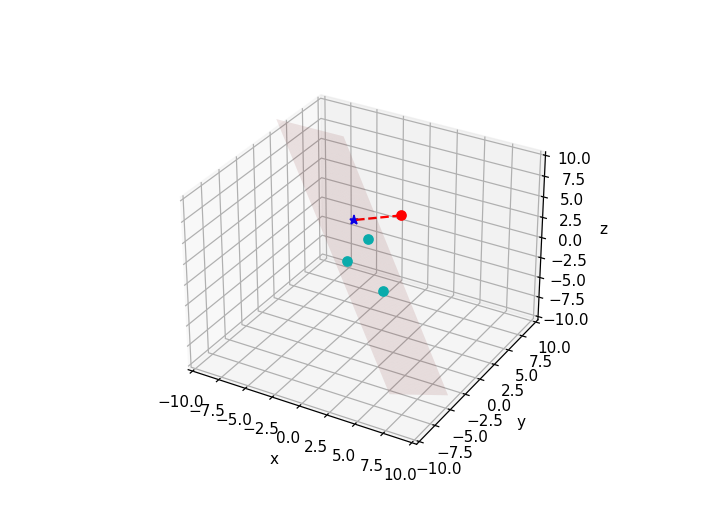

.
----------------------------------------------------------------------
Ran 1 test in 0.042s

OK


In [25]:
if IN_JUPYTER:
    def test_plane(self):
        
        Verbose.VERBOSITY=VERB_SIMPLE
        
        plt.close("all")
        
        #Calculate plane

        #Test plane
        p1=[-1,2,1]
        p2=[0,-3,2]
        p3=[1,1,-4]
        plane=Science.Plane(p1,p2,p3)
        print(plane)
        #Debe dar: {'a': 26, 'b': 7, 'c': 9, 'd': 3}
        
                #Check if point is above with respect to a direction
        p=[2,2,5]
        print("Is above: ",plane.is_above(p,[0,0,-1]))
        
        v=plane.get_projection(p)
        print("Projection: ",v)
        plane.plot_plane(p=p,alpha=0.1,color='r')

        Verbose.VERBOSITY=VERB_NONE

    class Test(unittest.TestCase):pass
    Test.test_plane=test_plane
    unittest.main(argv=['first-arg-is-ignored'],exit=False)

--End--